In [2]:
using GaussQuadrature, FastGaussQuadrature, SpecialFunctions, LinearAlgebra, Plots, GenericSVD

On the curve $x^4 + y^4 = 1$, use the inner product
$$
\langle f, g \rangle = \int_{-1}^{1} \left[ f(x,y)g(x,y) + f(x,-y)g(x,-y)\right]\mathrm{d}x, \qquad y = \sqrt[4]{1-x^4}.
$$
Note that $\langle x^i, y^j \rangle = 0$ if $i$ or $j$ is odd. For even $i$ and $j$,
$$
\langle x^i, y^j \rangle = 2\int_{-1}^{1} x^i y^j \mathrm{d}x = \frac{(1+(-1)^i)\Gamma(j/4+1)\Gamma(i/4 +1/4)}{2\Gamma(j/4+5/4+i/4)}=
 \frac{(1+(-1)^i)}{2}\mathrm{B}(j/4+1,i/4 +1/4),
$$
thus we have an explicit expression for the moments in terms of the Beta function.

To procede with the Gram-Schmidt procedure, we'll see that we'll have to compute inner products/moments of the form $\langle x^i, y^j \rangle$, for $i\geq 0$ and $j = 0, 2, 4, 6$. Some experimentation suggests that the rate of convergence of Gauss-Legendre quadrature for $\langle x^i, y^j \rangle$ is $\mathcal{O}\left(n^{-2-j/2}  \right)$ if $\text{mod}(j,4) \neq 0$. Here is an example for the case $j=2$:

In [3]:
# the exact value of the moment
i = 300
j = 2
exact = (1/2)*(1+(-1)^i)*beta(j/4+1,i/4+1/4)

0.0013509225946603193

 17.618738 seconds (103.03 k

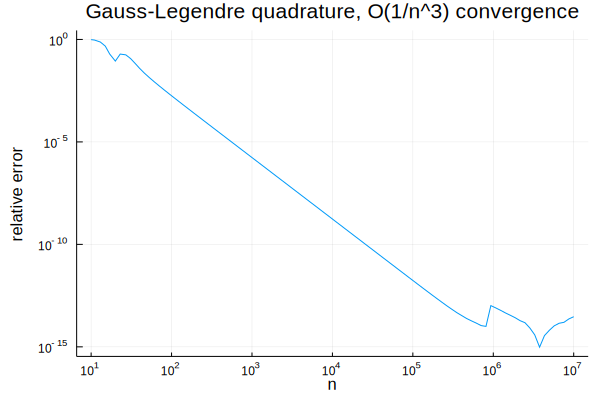

 allocations: 3.438 GiB, 15.73% gc time)


In [6]:
# Gauss-Legendre quadrature
f = x-> 2*x.^i.*(1 .-x.^4).^(j/4)
nv = round.(exp10.(range(1,stop=7,length=100)))
@time errs = [((nodes, weights) = gausslegendre( Int64(k) );abs((dot(weights,f(nodes)) - exact)/exact)) for k = nv];
plot(nv,errs;xscale=:log10, yscale=:log10, legend=false, xlabel="n",ylabel="relative error",title="Gauss-Legendre quadrature, O(1/n^3) convergence")

Use BigFloat due to the instability of the Gram-Schmidt procedure:

In [8]:
digits = 300
p = Int64(round(-log(10.0^(-digits))/log(2)+1))
setprecision(p)
eps(BigFloat)

7.4661089480257510319207163577905373569367315709736641969737147183677352878062050756355226167830488188767599194425939409937239001708322591587321665376314460498752853291066012021919606078872146520888039263701209049459241001183674703264414261690033208304855870308354118489557585138292876737761413032835424e-301

In [89]:
# Gauss-Legendre nodes
n = 2000;
@time x, w = jacobi(n,BigFloat(0),BigFloat(0));

117.506305 seconds (602.14 M allocations: 50.595 GiB, 14.36% gc time)


In [90]:
# Check the accuracy of these quadrature nodes and weights
i = BigFloat(300);
j = BigFloat(2);
exact = (1/2)*(1+(-1)^i)*beta(j/4+1,i/4+1/4)
ip(f,g) = 2*dot(w,f.*g)
norm(f) = sqrt(ip(f,f))
y = (1 .- x.^4).^(0.25)
glapprox=ip(x.^i,y.^j)
relerr=abs(1-glapprox/exact)

2.1542256738720761120224471429640411162842361412366270168480046297028348903159488804342301700354481555355797307532085474781459964636404866969276903260684069367854299212178282881443039371628992405047825639041198580802243306429347806236047288694394149096603893780076655728703093375924104034588427232733e-07

The orthonormal polynomials satisfy
$$
xQ_n = \left( B_{n-1}^x \right)^{\intercal} Q_{n-1} + A_n^x Q_n + B_{n}^xQ_{n+1}, \qquad Q_n = \left[ p_n \:
q_n\: 
r_n \:
s_n\: \right]^{\intercal}.
$$
$Q_0$ is a scalar such that
$$
Q_0 = \frac{1}{\| 1 \|}.
$$
From the properties of the inner product it follows that
$$
A_0^x = \langle xQ_0, Q_0 \rangle = 0 = \langle yQ_0, Q_0 \rangle = A_0^y.
$$
Thus, 
$$
\left[ B_0^x Q_1,  B_0^y Q_1 \right]  = \left[ xQ_0, yQ_0  \right].
$$
Applying the Gram-Schmidt procedure, we find:
$$
p_1 = \frac{Q_0}{\| xQ_0 \|}x, \qquad u_1 = yQ_0 - \langle yQ_0, p_1\rangle p_1 = yQ_0, \qquad q_1 = \frac{u_1}{\| u_1 \|} = \frac{Q_0}{\| yQ_0 \|}y.
$$
Hence, 
$$
B_0^x = \left[\| xQ_0 \| \quad  0 \right], \qquad B_0^y = \left[0 \quad \| yQ_0 \| \right]
$$

In [92]:
Q0 = BigFloat(1)*ones(n,1)/norm(ones(n,1));
b0x = [norm(x.*Q0) 0]
b0y = [0 norm(y.*Q0)]
p1 = Q0/b0x[1,1].*x
q1 = Q0/b0y[1,2].*y;
b0x

1×2 Array{BigFloat,2}:
 0.57735  0.0

In [93]:
b0y

1×2 Array{BigFloat,2}:
 0.0  0.93489

Proceding with the Gram-Schmidt procedure for $n=1$, we find
$$
A_1^x = \langle x Q_1 Q_1^{\intercal} \rangle =  \left(
\begin{array}{c c}
\langle xp_1, p_1\rangle & \langle xp_1, q_1\rangle \\
\langle xq_1, p_1\rangle & \langle xq_1, q_1\rangle
\end{array}
\right) = 
\left(
\begin{array}{c c}
0 & 0 \\
0 & 0
\end{array}
\right) =  \langle y Q_1 Q_1^{\intercal} \rangle = A_1^y,
$$
because $p_1 \in \lbrace x \rbrace$ and $q_1 \in \lbrace y \rbrace$. We denote $\text{span}\lbrace x \rbrace$ by $\lbrace x \rbrace$ for brevity.  Hence,
$$
xQ_1 - \left(B_0^x\right)^{\intercal}Q_0 = B_1^x Q_2 =
\left(
\begin{array}{c}
xp_1 - b_{1,1}^{0,x}Q_0  \\
xq_1   
\end{array}
\right)
=
\left(
\begin{array}{l}
u_1 \in \lbrace x^2,1 \rbrace \\
u_2 \in \lbrace xy \rbrace 
\end{array}
\right)
$$
$$
yQ_1 - \left(B_0^y\right)^{\intercal}Q_0 = B_1^y Q_2= 
\left(
\begin{array}{c}
yp_1   \\
yq_1 - b_{1,2}^{0,y}Q_0 
\end{array}
\right)
= 
\left(
\begin{array}{c}
u_3   \in \lbrace xy \rbrace \\
u_4  \in \lbrace y^2,1 \rbrace 
\end{array}
\right)
$$
\begin{eqnarray}
    p_2 &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^2, 1 \rbrace\\
    v_2 &=& u_2 - \langle u_2, p_2  \rangle p_2 = u_2, \qquad q_2 = \frac{u_2}{\| u_2 \|}  \in \lbrace xy \rbrace\\
    v_3 &=& u_4 - \langle u_4, p_2  \rangle p_2 - \langle u_4, q_2  \rangle q_2 = u_4 - \langle u_4, p_2  \rangle p_2 , \qquad r_2 = \frac{v_3}{\| v_3 \|}  \in \lbrace y^2, x^2, 1 \rbrace \\
    u_3 &=& \langle u_3, q_2 \rangle q_2
    \end{eqnarray}

$$
B_1^x = \left(
\begin{array}{c c c}
\| u_1 \| & & 0\\
 & \| u_2 \|  & 0 
\end{array}
\right)
\qquad
B_1^y = \left(
\begin{array}{c c c}
 & \langle u_3, q_2 \rangle  & \\
\langle u_4, p_2 \rangle  &   & \| v_3 \| 
\end{array}
\right)
$$

In [94]:
u1 = x.*p1 - b0x[1,1]*Q0
u2 = x.*q1
u3 = y.*p1
u4 = y.*q1 - b0y[1,2]*Q0
b1x = BigFloat(0)*zeros(2,3); b1y = BigFloat(0)*zeros(2,3)
b1x[1,1] = norm(u1)
b1x[2,2] = norm(u2)
p2 = u1/b1x[1,1]
q2 = u2/b1x[2,2]
b1y[2,1] = ip(u4,p2)
b1y[1,2] = ip(u3,q2)
v3 = u4 - b1y[2,1]*p2
b1y[2,3] = norm(v3);
r2 = v3/b1y[2,3]
b1x

2×3 Array{BigFloat,2}:
 0.516398  0.0      0.0
 0.0       0.52361  0.0

In [95]:
b1y

2×3 Array{BigFloat,2}:
  0.0       0.84787  0.0      
 -0.185526  0.0      0.0829017

In [96]:
# check the singular values
svdvals([u1 u2 u3 u4])

4-element Array{BigFloat,1}:
 23.545244758783707678697316299746263401807339004117298582768425214782405931918186228650625391207070598427905984127864507717001756753802372846656534984039045745225696822464675491133509544385492692249545547032049587138295374177153140493308653247020905596028621769377746764663787567004193291569326357548919      
 16.915968800261873330517718400099875973106825879902385216883314751599842697666596589243011106434829132118594061237682296188998677437744992685273885922734238706364443734028760374253321525298040536046765135829215495116478724619401344019798156679865327228541224035145310492954468387944043037908747733522882      
  2.5804883003553419313372405541797138293919096849494061966878608202127938437477633682956928549378949489354708278745345608700926864022632063790315897403488137739951001862862807604179543963639289111190981268291028637044928074271698132825982183627106253062110748374587012923176685096660050666779303626832982     
  1.8978973647581677294035161654090728

For $n=2$,
$$
A_2^x = \langle x Q_2 Q_2^{\intercal} \rangle =  0 =  \langle y Q_2 Q_2^{\intercal} \rangle = A_2^y,
$$
$$
xQ_2 - \left(B_1^x\right)^{\intercal}Q_1 = B_2^x Q_3 = \left(
\begin{array}{c}
xp_2 - b_{1,1}^{1,x} p_1   \\
xq_2 - b_{2,2}^{1,x} q_1   \\
xr_2 
\end{array}
\right)= \left(
\begin{array}{l}
u_1  \in \lbrace x^3,x \rbrace \\
u_2  \in \lbrace x^2y,y \rbrace \\
u_3  \in \lbrace xy^2,x^3,x \rbrace
\end{array}
\right)
$$
$$
yQ_2 - \left(B_1^y\right)^{\intercal}Q_1 = B_2^y Q_3 = \left(
\begin{array}{c}
yp_2 - b_{2,1}^{1,y} q_1   \\
yq_2 - b_{1,2}^{1,y} p_1   \\
yr_2 - b_{2,3}^{1,y} q_1
\end{array}
\right)= \left(
\begin{array}{l}
u_4  \in \lbrace x^2y,y \rbrace \\
u_5  \in \lbrace xy^2,x \rbrace \\
u_6  \in \lbrace y^3,x^2y,y \rbrace
\end{array}
\right)
$$
\begin{eqnarray}
p_3 &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^3, x \rbrace \\
q_3 &=& \frac{u_2}{\| u_2 \|} \in \lbrace x^2y, y \rbrace \\
v_3 &=& u_3 - \langle u_3, p_3  \rangle p_3, \qquad r_3 = \frac{v_3}{\| v_3\|} \in \lbrace xy^2,x^3,x \rbrace\\
v_4 &=& u_6 - \langle u_6, q_3 \rangle q_3, \qquad s_3 = \frac{v_4}{\| v_4 \|} \in \lbrace y^3,x^2y, y  \rbrace \\
u_4 &=& \langle u_4, q_3 \rangle q_3 + \langle u_4, s_3  \rangle s_3 \\
u_5 &=& \langle u_5, p_3 \rangle p_3 + \langle u_5, r_3  \rangle r_3
\end{eqnarray}
$$
B_2^x = \left(
\begin{array}{c c c c}
\|u_1 \| & & & 0\\
 & \| u_2 \| & & 0\\
 \langle u_3, p_3 \rangle &  & \| v_3 \| & 0
\end{array}
\right)
\qquad
B_2^y = \left( 
\begin{array}{c c c c}
 & \langle u_4, q_3 \rangle & & \langle u_4, s_3 \rangle \\
 \langle u_5, p_3\rangle & & \langle u_5, r_3 \rangle  & \\
 & \langle u_6, q_3 \rangle &  & \| v_4 \|
\end{array}
\right)
$$

In [97]:
u1 = x.*p2 - b1x[1,1]*p1
u2 = x.*q2 - b1x[2,2]*q1
u3 = x.*r2
u4 = y.*p2 - b1y[2,1]*q1
u5 = y.*q2 - b1y[1,2]*p1
u6 = y.*r2 - b1y[2,3]*q1
b2x = BigFloat(0)*zeros(3,4); b2y = BigFloat(0)*zeros(3,4)
b2x[1,1] = norm(u1)
b2x[2,2] = norm(u2)
p3 = u1/b2x[1,1]
q3 = u2/b2x[2,2]
b2x[3,1] = ip(u3,p3)
v3 = u3 - b2x[3,1]*p3
b2x[3,3] = norm(v3)
r3 = v3/b2x[3,3]
b2y[3,2] = ip(u6,q3)
v4 = u6 - b2y[3,2]*q3
b2y[3,4] = norm(v4)
s3 = v4/b2y[3,4]
b2y[2,1] = ip(u5,p3)
b2y[2,3] = ip(u5,r3)
b2y[1,2] = ip(u4,q3)
b2y[1,4] = ip(u4,s3)
b2x

3×4 Array{BigFloat,2}:
  0.507093  0.0       0.0       0.0
  0.0       0.496879  0.0       0.0
 -0.479595  0.0       0.652239  0.0

In [98]:
b2y

3×4 Array{BigFloat,2}:
  0.0       0.815823  0.0       9.74604e-301
 -0.255606  0.0       0.103267  0.0         
  0.0       0.294909  0.0       0.68679     

In [99]:
svdvals([u1 u2 u3 u4 u5 u6])

6-element Array{BigFloat,1}:
 43.907932830949036368124299504312085044278768554671726474676846795135807573177497769360528298841164448480745414722450208091672430615828469750754586570959055439529868849283369777967809111573591887652352167421556780234019825783964150061159994054055647692009233144208903413499513823402517078859272379629132      
 24.260498145132706243172795844796999506966015160742106901792912102844922218636952477651891853606637590414394136946963431263844396449927510912475783738665738566396077209969411914541255072521952617454858405563475343751586281367937446559569944392940847731316109380668461699250643319853376154056621155344705      
 19.916485235284625001551941414760491326382782016122544549386140222096772806209738003919673286755287983604487232193922865366157164049581859207281344694892946208159795896079562566214038286044319590676738839566611821010756166965785375543674202960066574453893716805570243471935155947043049116314555545914572      
  9.1163709051254866280722982032860986

For $n=3$,
$$
A_3^x = \langle x Q_3 Q_3^{\intercal} \rangle =  0 =  \langle y Q_3 Q_3^{\intercal} \rangle = A_3^y,
$$
$$
xQ_3 - \left(B_2^x\right)^{\intercal}Q_2  = B_3^x Q_4= \left(
\begin{array}{l}
xp_3 - b_{1,1}^{2,x} p_2 - b_{3,1}^{2,x}r_2   \\
xq_3 - b_{2,2}^{2,x} q_2   \\
xr_3 - b_{3,3}^{2,x} r_2                    \\
xs_3                   
\end{array}
\right)= \left(
\begin{array}{l}
u_1  \in \lbrace x^4,x^2,y^2,1 \rbrace \\
u_2  \in \lbrace x^3y,xy \rbrace \\
u_3  \in \lbrace x^2y^2,x^4,x^2,y^2,1 \rbrace  \\
u_4 \in \lbrace xy^3, x^3y, xy \rbrace
\end{array}
\right)
$$
$$
yQ_3 - \left(B_2^y\right)^{\intercal}Q_2  = B_3^y Q_4= \left(
\begin{array}{l}
yp_3 - b_{2,1}^{2,y} q_2     \\
yq_3 - b_{1,2}^{2,y} p_2 - b_{3,2}^{2,y}r_2   \\
yr_3 - b_{2,3}^{2,y} q_2                    \\
ys_3 - b_{1,4}^{2,y} p_2 - b_{3,4}^{2,y}r_2                  
\end{array}
\right)= \left(
\begin{array}{l}
u_5  \in \lbrace x^3y,xy \rbrace \\
u_6  \in \lbrace x^2y^2,y^2,x^2,1 \rbrace \\
u_7  \in \lbrace xy^3,x^3y,xy \rbrace  \\
u_8 \in \lbrace y^4, x^2y^2, y^2, x^2, 1 \rbrace
\end{array}
\right)
$$
\begin{eqnarray}
p_4 &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^4, x^2, y^2, 1 \rbrace \\
q_4 &=& \frac{u_2}{\| u_2 \|} \in \lbrace x^3y, xy\rbrace \\
v_3 &=& u_3 - \langle u_3, p_4 \rangle p_4, \qquad r_4 = \frac{v_3}{\| v_3 \|} \in \lbrace x^2y^2, x^4, x^2, y^2, 1  \rbrace\\
v_4 &=& u_4 - \langle u_4, q_4 \rangle q_4, \qquad     s_4 = \frac{v_4}{\| v_4 \|}  \in \lbrace xy^3, x^3y,xy \rbrace
\end{eqnarray}
$$ B_3^x = \left( 
\begin{array}{c c c c}
\| u_1 \| &             &   &     \\
          & \| u_2 \|   &   &      \\
\langle u_3,p_4 \rangle &   & \| v_3 \| & \\
 & \langle u_4, q_4 \rangle &  & \|v_4 \|
\end{array}
\right) \qquad
B_3^y = \left( 
\begin{array}{c c c c}
 & \langle u_5, q_4\rangle &    &  \langle u_5, s_4\rangle    \\
\langle u_6, p_4\rangle &  & \langle u_6, r_4\rangle   &      \\
 & \langle u_7, q_4\rangle &    &  \langle u_7, s_4\rangle  \\
\langle u_8, p_4\rangle &  & \langle u_8, r_4\rangle   &      \\
\end{array}
\right)
$$

In [100]:
u1 = x.*p3 - b2x[1,1]*p2 - b2x[3,1]*r2
u2 = x.*q3 - b2x[2,2]*q2
u3 = x.*r3 - b2x[3,3]*r2
u4 = x.*s3
u5 = y.*p3 - b2y[2,1]*q2
u6 = y.*q3 - b2y[1,2]*p2 - b2y[3,2]*r2
u7 = y.*r3 - b2y[2,3]*q2
u8 = y.*s3 - b2y[1,4]*p2 - b2y[3,4]*r2
b3x = BigFloat(0)*zeros(4,4); b3y = BigFloat(0)*zeros(4,4)
b3x[1,1] = norm(u1)
b3x[2,2] = norm(u2)
p4 = u1/b3x[1,1]
q4 = u2/b3x[2,2]
b3x[3,1] = ip(u3,p4)
v3 = u3 - b3x[3,1]*p4
b3x[3,3] = norm(v3)
r4 = v3/b3x[3,3]
b3x[4,2] = ip(u4,q4)
v4 = u4 - b3x[4,2]*q4
b3x[4,4] = norm(v4)
s4 = v4/b3x[4,4]
b3y[1,2] = ip(u5,q4)
b3y[1,4] = ip(u5,s4)
b3y[2,1] = ip(u6,p4)
b3y[2,3] = ip(u6,r4)
b3y[3,2] = ip(u7,q4)
b3y[3,4] = ip(u7,s4)
b3y[4,1] = ip(u8,p4)
b3y[4,3] = ip(u8,r4)
b3x

4×4 Array{BigFloat,2}:
 0.154779   0.0       0.0        0.0     
 0.0        0.500448  0.0        0.0     
 0.496906   0.0       0.0968232  0.0     
 0.0       -0.48348   0.0        0.623643

In [31]:
b3y

4×4 Array{BigFloat,2}:
  0.0        0.805133  0.0        -1.65793e-300
  0.0236507  0.0       0.0201229   0.0         
  0.0        0.309204  0.0         0.65668     
 -0.386902   0.0       0.044853    0.0         

In [101]:
svdvals([u1 u2 u3 u4 u5 u6 u7 u8])

8-element Array{BigFloat,1}:
 38.329007159970439467709886490442040308202424705545005890562526674331169981861124081619217430057877025619451022581184676414987648435505555619427218090580873768529185449512366831460483947142361120046610967391127995823716271460486336853178645415911256478508812213518112032990444265739800583876943488144765      
 29.53221496398769945396619135855083136236317618240510844445641688958550483494736718021459528740522283916861724449469962427462947755096416543574181892861712055977577050481666302389257296175431800207529320996275418532552416639215305256460021525012866724494560320710558074142277706065557333283446012139314       
 21.076478974106582790576821304186592475564922916567544071472440685356145328035649050926659070322455469815166738553337642968722499632264604549302466443876973614209603425454112678556242342968382398939199824414961294625051294181941465668875064013703344688723248542806117033868237546611726139442069987335173      
  3.2452487360936154207362420058810972

For $n\geq4$, 
$$
A_n^x = \langle x Q_n Q_n^{\intercal} \rangle =  0 =  \langle y Q_n Q_n^{\intercal} \rangle = A_n^y,
$$
$$
xQ_n - \left(B_{n-1}^x\right)^{\intercal}Q_{n-1}  = B_n^x Q_{n+1}= \left(
\begin{array}{l}
xp_n - b_{1,1}^{n-1,x} p_{n-1} - b_{3,1}^{n-1,x}r_{n-1}   \\
xq_n - b_{2,2}^{n-1,x} q_{n-1} - b_{4,2}^{n-1,x} s_{n-1}   \\
xr_n - b_{3,3}^{n-1,x} r_{n-1}                    \\
xs_n - b_{4,4}^{n-1,x} s_{n-1}                 
\end{array}
\right)= \left(
\begin{array}{l}
u_1  \\
u_2  \\
u_3   \\
u_4 
\end{array}
\right)
$$
$$
yQ_{n} - \left(B_{n-1}^y\right)^{\intercal}Q_{n-1}  = B_n^y Q_{n+1}= \left(
\begin{array}{l}
yp_n - b_{2,1}^{n-1,y} q_{n-1} - b_{4,1}^{n-1,y} s_{n-1}     \\
yq_n - b_{1,2}^{n-1,y} p_{n-1} - b_{3,2}^{n-1,y}r_{n-1}   \\
yr_n - b_{2,3}^{n-1,y} q_{n-1} - b_{4,3}^{n-1,y} s_{n-1}                  \\
ys_n - b_{1,4}^{n-1,y} p_{n-1} - b_{3,4}^{n-1,y}r_{n-1}                
\end{array}
\right)= \left(
\begin{array}{l}
u_5  \\
u_6   \\
u_7  \\
u_8 
\end{array}
\right)
$$
\begin{eqnarray}
p_{n+1} &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^{n+1}, x^{n-1}, x^{n-3}y^2, \ldots, x^{n+3-2\lfloor (n+1)/2 \rfloor}, x^{n+1-2\lfloor (n+1)/2 \rfloor}y^2, x^{n+1-2\lfloor (n+1)/2 \rfloor}  \rbrace \\
q_{n+1} &=& \frac{u_2}{\| u_2 \|} \in \lbrace x^{n}y, x^{n-2}y, x^{n-4}y^3, \ldots, x^{n+2-2\lfloor n/2 \rfloor}y, x^{n-2\lfloor n/2 \rfloor}y^3, x^{n-2\lfloor n/2 \rfloor}y  \rbrace  \\
v_3 = u_3 - \langle u_3, p_{n+1} \rangle p_{n+1}, \qquad r_{n+1} &=& \frac{v_3}{\| v_3 \|}  \in \lbrace x^{n-1}y^2, x^{n+1}, x^{n-1}, x^{n-3}y^2, \ldots, x^{n+3-2\lfloor (n+1)/2 \rfloor}, x^{n+1-2\lfloor (n+1)/2 \rfloor}y^2, x^{n+1-2\lfloor (n+1)/2 \rfloor}  \rbrace\\
v_4 = u_4 - \langle u_4, q_{n+1} \rangle q_{n+1}, \qquad     s_{n+1} &=& \frac{v_4}{\| v_4 \|} \in \lbrace x^{n-2}y^3, x^{n}y, x^{n-2}y, x^{n-4}y^3, \ldots, x^{n+2-2\lfloor n/2 \rfloor}y, x^{n-2\lfloor n/2 \rfloor}y^3, x^{n-2\lfloor n/2 \rfloor}y  \rbrace
\end{eqnarray}
$$ B_n^x = \left( 
\begin{array}{c c c c}
\| u_1 \| &             &   &     \\
          & \| u_2 \|   &   &      \\
\langle u_3,p_{n+1} \rangle &   & \| v_3 \| & \\
 & \langle u_4, q_{n+1} \rangle &  & \|v_4 \|
\end{array}
\right) \qquad
B_n^y = \left( 
\begin{array}{c c c c}
 & \langle u_5, q_{n+1}\rangle &    &  \langle u_5, s_{n+1}\rangle    \\
\langle u_6, p_{n+1}\rangle &  & \langle u_6, r_{n+1}\rangle   &      \\
 & \langle u_7, q_{n+1}\rangle &    &  \langle u_7, s_{n+1}\rangle  \\
\langle u_8, p_{n+1}\rangle &  & \langle u_8, r_{n+1}\rangle   &      \\
\end{array}
\right)
$$


In [102]:
@time begin
    nmax =500;
    bx = BigFloat(0)*zeros(4,4,nmax+1); by = BigFloat(0)*zeros(4,4,nmax+1)
    bx[:,:,1] = b3x; by[:,:,1] = b3y; 
    pn=p4;qn=q4;rn=r4;sn=s4
    po=p3;qo=q3;ro=r3;so=s3;
    sv5=BigFloat(0)*zeros(nmax,1)
    sv4=BigFloat(0)*zeros(nmax,1)
    for k = 1:nmax
        u1 = x.*pn - bx[1,1,k]*po - bx[3,1,k]*ro
        u2 = x.*qn - bx[2,2,k]*qo - bx[4,2,k]*so
        u3 = x.*rn - bx[3,3,k]*ro
        u4 = x.*sn - bx[4,4,k]*so
        u5 = y.*pn - by[2,1,k]*qo - by[4,1,k]*so
        u6 = y.*qn - by[1,2,k]*po - by[3,2,k]*ro
        u7 = y.*rn - by[2,3,k]*qo - by[4,3,k]*so
        u8 = y.*sn - by[1,4,k]*po - by[3,4,k]*ro
        bx[1,1,k+1] = norm(u1)
        bx[2,2,k+1] = norm(u2)
        pn1 = u1/bx[1,1,k+1]
        qn1 = u2/bx[2,2,k+1]
        bx[3,1,k+1] = ip(u3,pn1)
        v3 = u3 - bx[3,1,k+1]*pn1
        bx[3,3,k+1] = norm(v3)
        rn1 = v3/bx[3,3,k+1]
        bx[4,2,k+1] = ip(u4,qn1)
        v4 = u4 - bx[4,2,k+1]*qn1
        bx[4,4,k+1] = norm(v4)
        sn1 = v4/bx[4,4,k+1]
        by[1,2,k+1] = ip(u5,qn1)
        by[1,4,k+1] = ip(u5,sn1)
        by[2,1,k+1] = ip(u6,pn1)
        by[2,3,k+1] = ip(u6,rn1)
        by[3,2,k+1] = ip(u7,qn1)
        by[3,4,k+1] = ip(u7,sn1)
        by[4,1,k+1] = ip(u8,pn1)
        by[4,3,k+1] = ip(u8,rn1)
        po.=pn;qo.=qn;ro.=rn;so.=sn
        pn.=pn1;qn.=qn1;rn.=rn1;sn.=sn1
        s=svdvals([u1 u2 u3 u4 u5 u6 u7 u8])
        sv5[k]=s[5];
        sv4[k]=s[4];
    end
end

171.367611 seconds (652.45 M allocations: 63.434 GiB, 21.96% gc time)


Here is a plot of the fourth and fifth largest singular values of the matrix $[u_1\: u_2\: \cdots\: u_8]$ that should have rank 4; it shows the exponential instability of the Gram-Schmidt process:

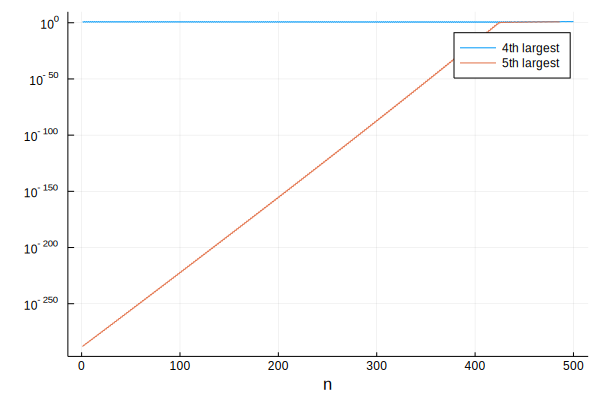

In [103]:
plot(sv4;yscale=:log10,label="4th largest",xlabel="n")
plot!(sv5[15:end];label="5th largest")

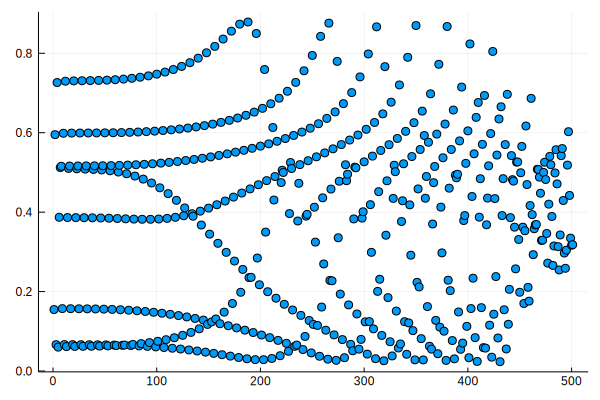

In [108]:
# Plot the (1,1) entry of B_n^x:
scatter(bx[1,1,:],legend=false)

From this plot it appears the results are completely incorrect from the start even when the matrix $[u_1\: u_2\: \cdots \: u_8]$ has rank 4 to many digits, why?